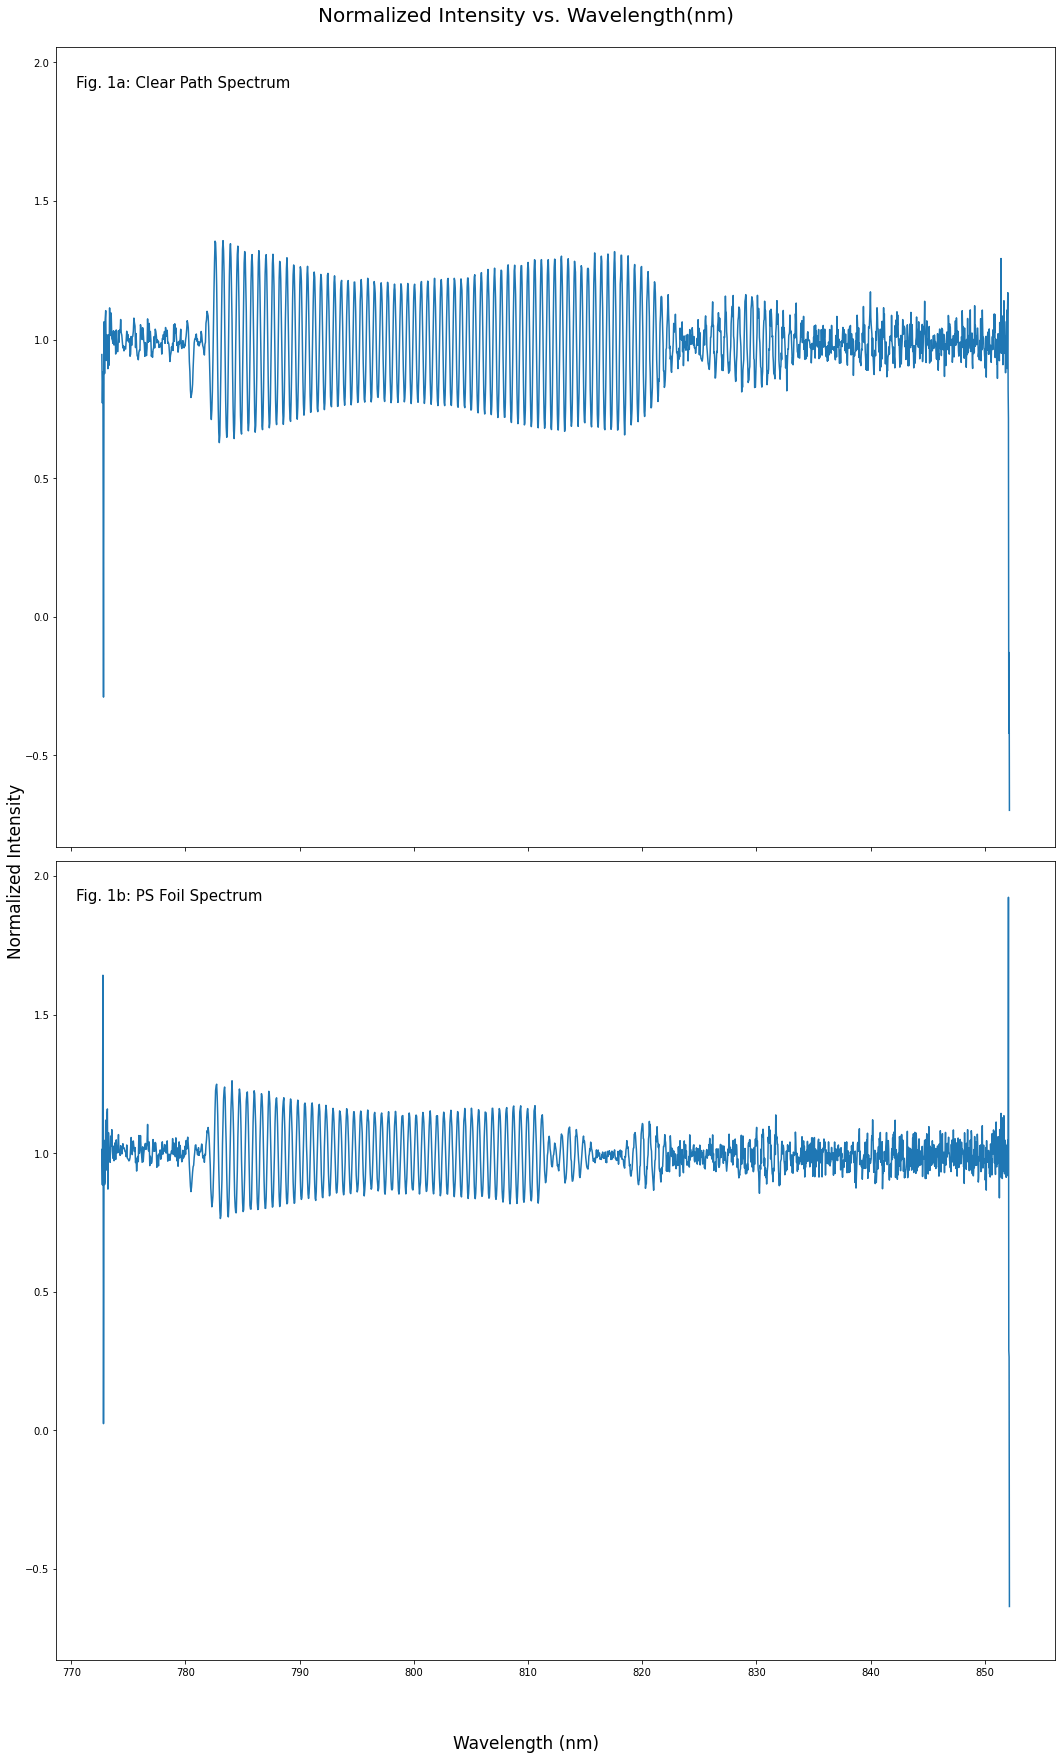

In [35]:
from scipy.signal import hilbert, chirp
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.fft import fft, ifft
import pandas as pd
import numpy as np
import pandas as pd
import cmath

#reading the files

df_1=pd.read_csv("MidIR_Blocked_300ms_delay01_subt2.csv",sep="	")
df_2=pd.read_csv("Clear_Path_300ms_delay01_subt2.csv",sep="	")
df_3=pd.read_csv("PS_Foil_300ms_delay01_subt2.csv",sep="	")

#normalization of the spectra 2&3 by SPDC spectrum 
df_2["Intensity"] /= df_1["Intensity"]
df_3["Intensity"] /= df_1["Intensity"]

#renaming the intensity column as normalized intensity
df_2.rename(columns = {"Intensity":"Norm_Intensity"}, inplace = True)
df_3.rename(columns = {"Intensity":"Norm_Intensity"}, inplace = True)


#plotting the spectra 2&3 in wavelength domain
fig, axes = plt.subplots(2, figsize = (15, 25), sharex = True, sharey = True)
fig.suptitle("Normalized Intensity vs. Wavelength(nm)", size = 20)
axes[0].plot(df_2["Wavelength(nm)"], df_2["Norm_Intensity"])
axes[1].plot(df_3["Wavelength(nm)"], df_3["Norm_Intensity"])
axes[0].annotate('Fig. 1a: Clear Path Spectrum', xy=(0.02, 0.95), xycoords='axes fraction', fontsize=15)
axes[1].annotate('Fig. 1b: PS Foil Spectrum', xy=(0.02, 0.95), xycoords='axes fraction', fontsize=15)
fig.supxlabel("Wavelength (nm)", size = 17)
fig.supylabel("Normalized Intensity", size = 17)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
fig.savefig("Plot_1.png")

In [37]:
c = 3e+8;
#converting wavelength domain into frequency domain for clear path spectrum
df_2["Frequency(s^(-1))"] = np.array((c*1e+9)/df_2["Wavelength(nm)"])
interp = interpolate.interp1d(df_2["Frequency(s^(-1))"],df_2["Norm_Intensity"],kind="cubic")

#oversampling the frequency axis by factor 3
#adding extra two rows in between the successive rows
insert_rows = 3 
df_2.index = range(0, insert_rows * len(df_2), insert_rows)
# create new_df with added rows
new_df2 = df_2.reindex(index = range(insert_rows * len(df_2)))

#creating equidistant frequency array for discrete Fourier transform
x2 = new_df2["Frequency(s^(-1))"].interpolate()
X2=np.array(x2)
eq_freq_array2=np.linspace(X2[0], X2[6203], 6204)

#finding corresponding intensities
norm_intensity2 = interp(eq_freq_array2)


#forming the new data frame
df_corrected2 = pd.DataFrame(list(zip(eq_freq_array2, norm_intensity2)),columns=["frequency(s^(-1))", "norm intensity"])
df_corrected2["frequency(s^(-1))"] *= 2*np.pi

#converting frequency domain into angular frequency domain
df_corrected2.rename(columns = {"frequency(s^(-1))":"angular frequency"}, inplace = True)
df_corrected2

,angular frequency,norm intensity
0,2.439526e+15,0.946247
1,2.439489e+15,0.684592
2,2.439452e+15,0.598854
3,2.439416e+15,0.638597
4,2.439379e+15,0.753384
...,...,...
6199,2.212131e+15,-0.409294
6200,2.212094e+15,-0.407191
6201,2.212058e+15,-0.133404
6202,2.212021e+15,-0.069745


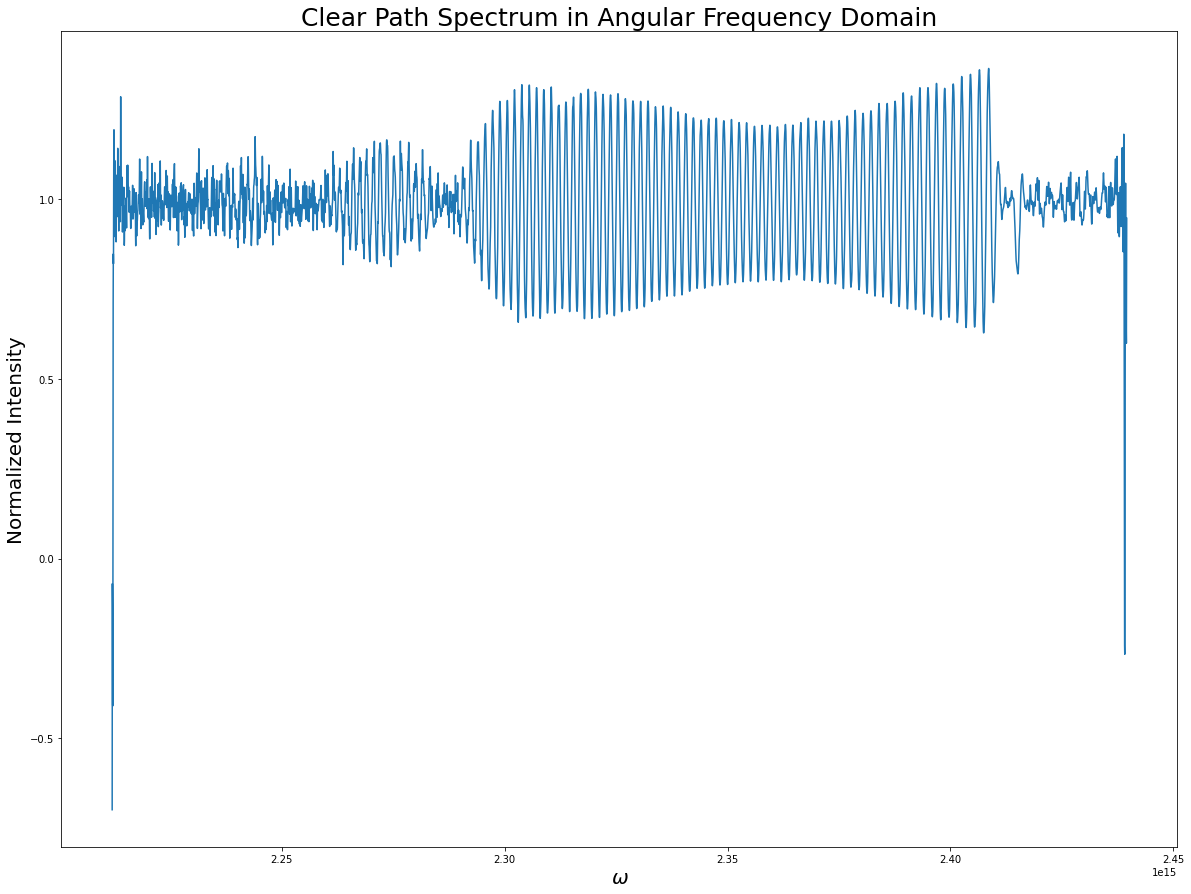

In [38]:
fig, ax = plt.subplots(figsize=(20, 15))
ax.plot(df_corrected2["angular frequency"],df_corrected2["norm intensity"])
ax.set_xlabel("$\omega$", size=20)
ax.set_ylabel("Normalized Intensity", size = 20)
ax.set_title("Clear Path Spectrum in Angular Frequency Domain", size = 25)
fig.savefig("Plot_2.png")

In [39]:
#applying inverse Fourier transform to intensity
y2 = ifft(np.array(df_corrected2["norm intensity"]))
#calculating the phase shift caused by dispersion
dispersion_phase = np.angle(y2,deg=False)
df_corrected2["dispersion phase"] = dispersion_phase
magnitude = abs(y2)

In [40]:
def function(array):
    for i in range(len(array)):
        if str(array[i])[0:4] == "2285":
            for j in range(len(array)):
                if str(array[j])[0:3] == "236":
                    return (i, j) 

idx = function(df_corrected2["angular frequency"])
X = np.array(df_corrected2.loc[idx[1] : idx[0] + 1 , ["angular frequency"]])
Y = np.array(df_corrected2.loc[idx[1] : idx[0] + 1 , ["dispersion phase"]])
p = np.polyfit(X.flatten(), Y.flatten(), 1)

l_f_disp_phase = p[0] * df_corrected2["angular frequency"] + p[1]
df_corrected2["linearly fit disp phase"] = l_f_disp_phase

Text(0, 0.5, 'dispersion phase (linear fitting)')

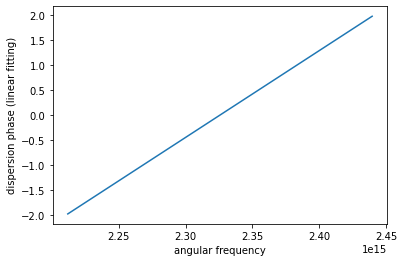

In [41]:
#applying Fourier transform back
y_in_exp_form2 = magnitude*np.exp(1j*np.array(l_f_disp_phase))
Y2 = fft(y_in_exp_form2)
df_corrected2["corrected phase"] = np.angle(Y2, deg=False) #they are all nearly zero
df_corrected2

plt.plot(df_corrected2["angular frequency"],l_f_disp_phase)
plt.xlabel("angular frequency")
plt.ylabel("dispersion phase (linear fitting)")

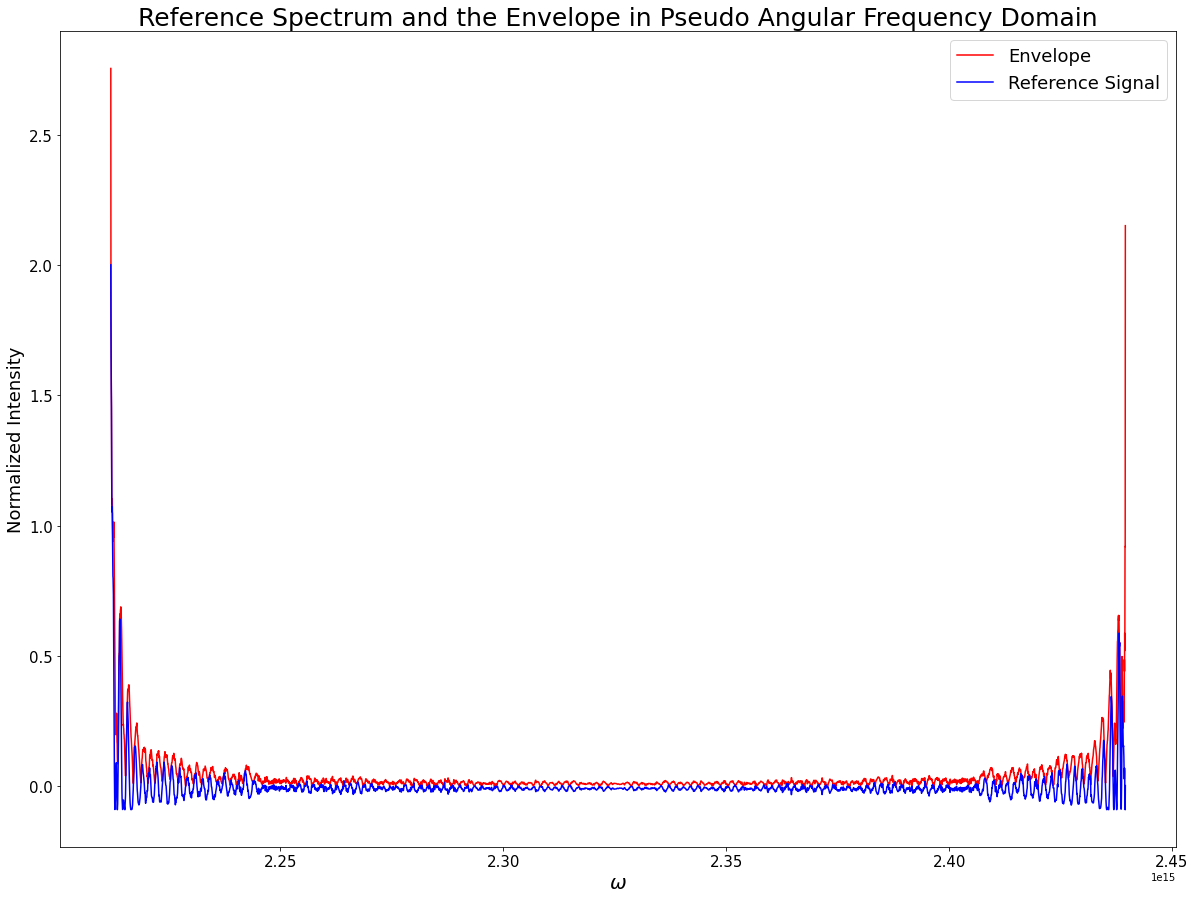

In [47]:
#finding the envelope of the signal
zero_centered = abs(Y2) - np.mean(abs(Y2))
analytic_signal = hilbert(zero_centered)
amplitude_envelope = np.abs(analytic_signal)
fig, ax = plt.subplots(figsize=(20, 15))
ax.plot(df_corrected2["angular frequency"], amplitude_envelope, color = "r")
ax.plot(df_corrected2["angular frequency"], zero_centered, color = "b")
ax.legend(["Envelope", "Reference Signal"], fontsize = 18)
plt.xlabel("${\omega}^{~}$", fontsize = 20)
plt.ylabel("Normalized Intensity", fontsize = 18)

plt.title("Reference Spectrum and the Envelope in Pseudo Angular Frequency Domain",fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
df_corrected2.to_csv("New_Clear_Path_300ms_delay01_subt2.csv", sep = "\t", index = False)

In [14]:
#converting wavelength axis into frequency axis (PS Foil)
freq_array3 = np.array((c*1e+9)/df_3["Wavelength(nm)"])
df_3["Frequency(s^(-1))"] = freq_array3
interp = interpolate.interp1d(df_3["Frequency(s^(-1))"],df_3["Norm_Intensity"],kind="cubic")

#oversampling the frequency axis by factor 3
new_df3 = df_3.reindex(index = range(insert_rows * len(df_3)))

#creating equidistant frequency array for discrete Fourier transform
x3 = new_df3["Frequency(s^(-1))"].interpolate()
X3=np.array(x3)
eq_freq_array3=np.linspace(X3[0], X3[6203], 6204)
norm_intensity3 = interp(eq_freq_array3)

#forming the new data frame
df_corrected3 = pd.DataFrame(list(zip(eq_freq_array3, norm_intensity3)),columns=["frequency", "norm intensity"])
df_corrected3

,frequency,norm intensity
0,3.882626e+14,1.013398
1,3.882567e+14,0.581093
2,3.882509e+14,0.464995
3,3.882450e+14,0.580961
4,3.882392e+14,0.844851
...,...,...
6199,3.520716e+14,0.311483
6200,3.520657e+14,0.082482
6201,3.520599e+14,0.261171
6202,3.520541e+14,0.228326


In [11]:
#applying inverse Fourier transform to intensity
y3 = ifft(np.array(df_corrected3["norm intensity"]))
y_in_exp_form3 = y3*np.exp(-1j*np.array(l_f_disp_phase))
Y3 = fft(y_in_exp_form3)

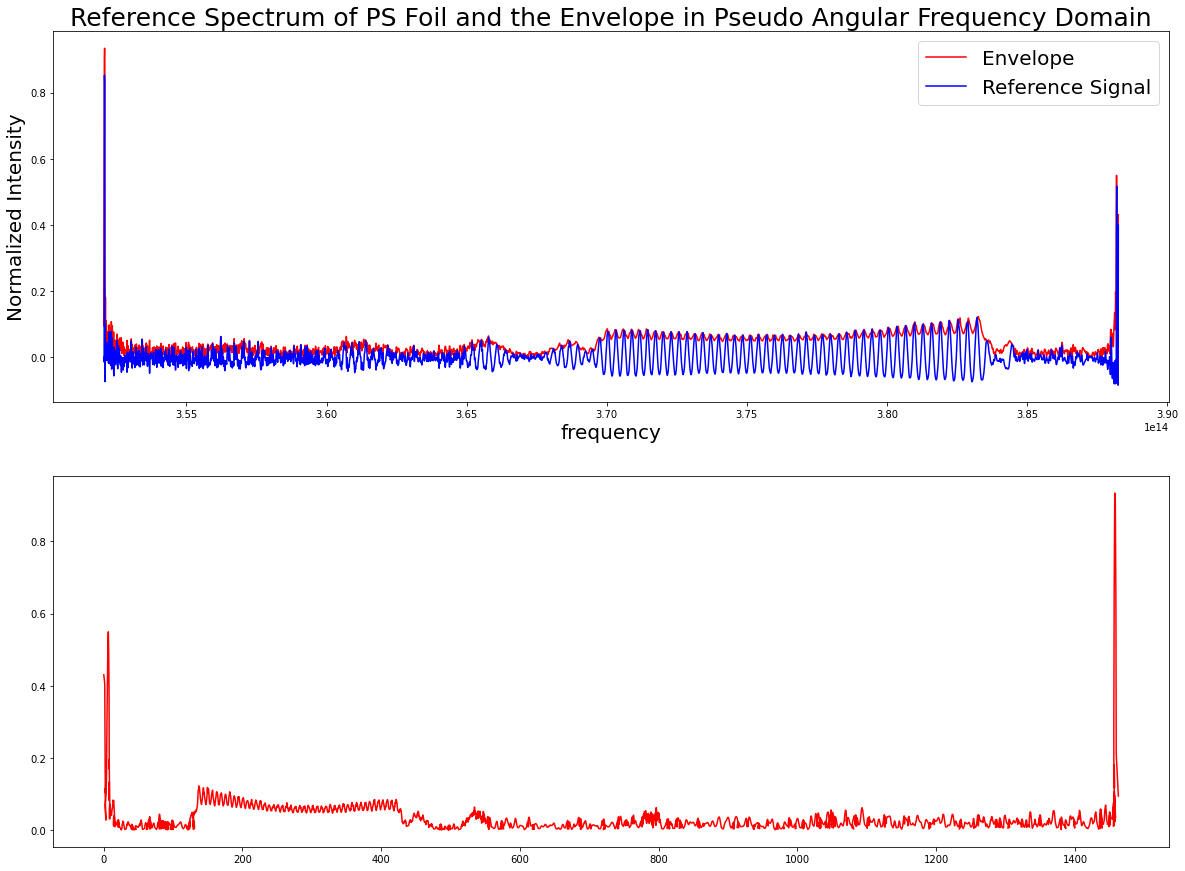

In [34]:
#removing the DC offset from the signal
zero_centered3=abs(Y3) - np.mean(abs(Y3))
#finding the envelope of the signal
analytic_signal3 = hilbert(zero_centered3)
amplitude_envelope3 = np.abs(analytic_signal3)
instantaneous_phase = np.unwrap(np.angle(analytic_signal3))
fig, ax = plt.subplots(2,1,figsize=(20, 15))
ax[0].plot(df_corrected3["frequency"], amplitude_envelope3, color = "r")
ax[0].plot(df_corrected3["frequency"], zero_centered3, color = "b")

ax[0].legend(["Envelope", "Reference Signal"], fontsize = 20)
ax[0].set_xlabel("frequency", fontsize = 20)
ax[0].set_ylabel("Normalized Intensity", fontsize = 20)
ax[0].set_title("Reference Spectrum of PS Foil and the Envelope in Pseudo Angular Frequency Domain",fontsize = 25)
ax[1].plot(instantaneous_phase, amplitude_envelope3, color = "r")

array([772.673     , 772.68461865, 772.69623765, ..., 852.12773744,
       852.14186849, 852.156     ])

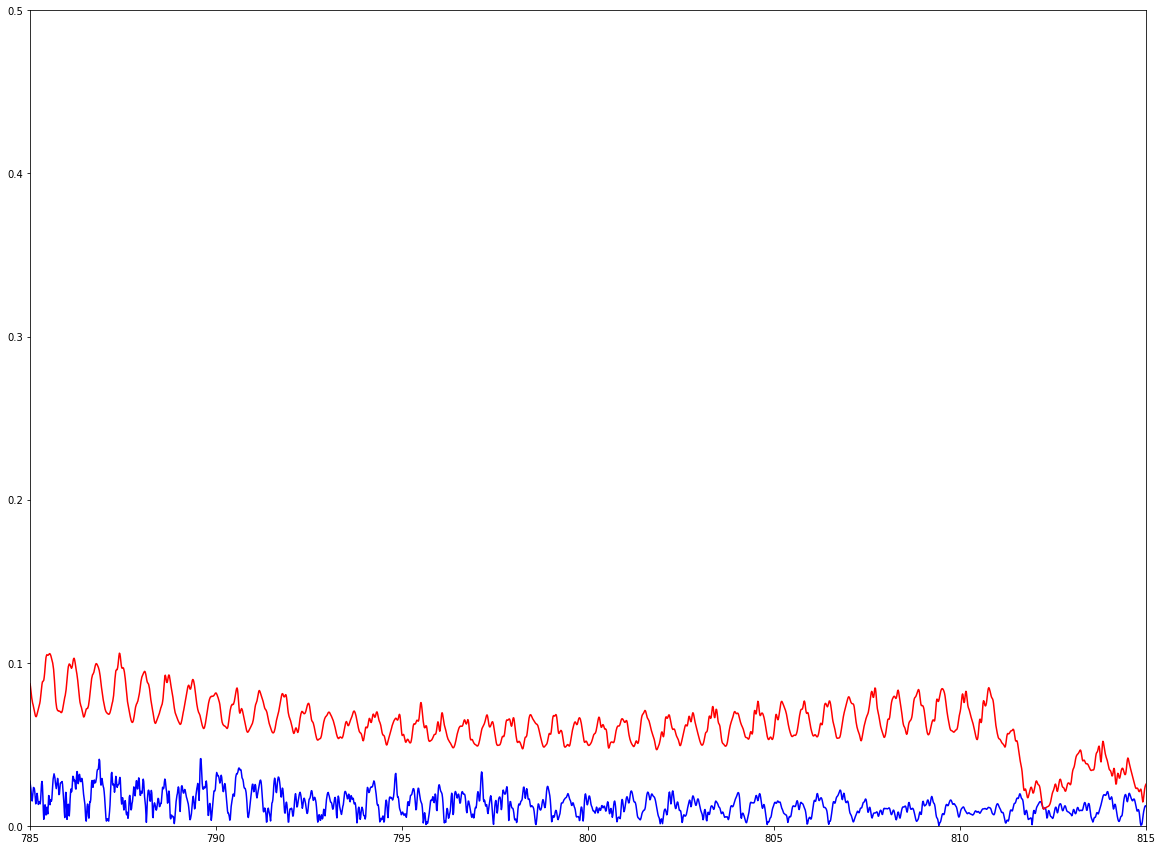

In [23]:
fig, ax = plt.subplots(figsize=(20, 15))
wavelength_axis = (c * 1e+9) / np.array(df_corrected3["frequency"])
ax.plot(wavelength_axis, amplitude_envelope, color = "b")
ax.plot(wavelength_axis, amplitude_envelope3, color = "r")
ax.set_xlim([785, 815])
ax.set_ylim([0, 0.5])
wavelength_axis

In [359]:
b = amplitude_envelope3/amplitude_envelope #transmission
